# Lab 10 - Generative Adversarial Networks (GANs)

In this lab you'll use [PyTorch](https://pytorch.org/) to train a *generative adversarial network* on synthetic data. Here is the original publication that introduced GANs:

* Goodfellow et al. **Generative Adversarial Nets**, NeurIPS 2014 ([PDF](http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf))

GANs will be covered in lecture. Lab 10 introduces the basics and provides enough starter code to try GANs out for yourself.

**What are GANs?**

GANs are a type of *generative* model. That means that, at the very least, we can generate samples from the model after it's trained; if training went well, those samples should qualitatively resemble the data that we used to train the generative model.

You have already trained a generative model: the GMMs in Lab 3. However, GANs are based on neural networks and are more flexible.

If we sample from an untrained GAN, we get useless random noise. The same is true of sampling from an untrained GMM.

If we sample from a *trained* GAN, we get data that qualitatively resembles the training data. Again, this is similar to training a GMM, except GANs don't assume the training data is a mixture of Gaussians.

**What makes GANs "adversarial"?**

GANs are trained according to a very intuitive criterion:

<blockquote>If the samples drawn from a GAN are <em>indistinguishable</em> from the real data, then they are good samples!
</blockquote>

*The GAN training objective therefore aims to "minimize distinguishability."* It is of course possible to just memorize the training data, but that is a trivial kind of overfitting.

In the GAN training setup, distinguishability is measured by the degree to which a second model, the *discriminator*, is able to classify real versus fake (generated) data. If the discriminator model cannot tell the difference between real and fake, then it must mean the samples we draw from the generator (the GAN) are realistic.

The discriminator and generator are thus in competition, as adversaries:
* the generator's weights are being adjusted to better "fool" the discriminator, tricking it into classifying fake data as "real."
* the discriminator's weights are being adjusted to better distinguish (classify) the generator's data as "fake."

Once the training is complete, the discriminator is typically thrown away&mdash;its sole job is to provide a constant "challenge" to the generator throughout the generator's training process.

**How is GAN training formulated?**

The problem setup is as follows:
* You are given training samples $\{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$ with $\mathbf{x}_i \in \mathbb{R}^M$ that represent "real" data, for example hand-written digits.
* Your goal is to train the weights $\mathbf{w}$ of a generative model $G_\mathbf{w} : \mathbb{R}^K \rightarrow \mathbb{R}^M$ so that it can transform samples $\mathbf{z} \in \mathbb{R}^K$ from a standard distribution (*e.g.* uniform, normal) into points $\mathbf{\tilde{x}} \in \mathbb{R}^M$ that are indistinguishable from the real data.
* Distinguishability is measured by a discriminator model $D_\mathbf{w} : \mathbb{R}^M \rightarrow \mathbb{R}$ that takes either a real $\mathbf{x}_i$ or a fake $\mathbf{\tilde{x}}$ sample as input and classifies it as real (1) or fake (0); the discriminator has its own distinct weights $\mathbf{w}$ that need to be continually trained to "keep up" with improvements to the generator $G$.

Therefore, the training loop should try to achieve three things:
1. Train $D$ to predict "real" ($\hat{y}=1$) when evaluating $\hat{y} = D(\mathbf{x}_i)$ for any real training point $\mathbf{x}_i$.
2. Train $D$ to predict "fake" ($\hat{y}=0$) when evaluating $\hat{y} = D(\mathbf{\tilde{x}})$ for any fake data point $\mathbf{\tilde{x}} = G(\mathbf{z})$.
3. Train $G$ to make $D$ predict "real" ($\hat{y}=1$) when evaluating $\hat{y} = D(\mathbf{\tilde{x}})$ for any fake data point $\mathbf{\tilde{x}} = G(\mathbf{z})$.

The training scheme is "adversarial" because the 2nd and 3rd items are competing objectives, *i.e.* the generator and discriminator are "fighting" over whether to predict $1$ (real) or $0$ (fake) when the discriminator classifies a fake data point.


**Run the code cell below** to import the required packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time      # for sleep
import IPython   # for display, clear_output
np.set_printoptions(precision=3, suppress=True)  # Print array values as 0.0023 instead of 2.352e-3
torch.set_printoptions(precision=3, sci_mode=False)

One of the exercises will ask you to generate a plot that keeps updating as your GAN is trained.

**Run the code cell below** to view a demo of how to **animate a plot**. You can use this code as a reference for how to animate your plots later in the lab. <span style="color:red">Note that you cannot also use the *print* function in a loop where you also update the plot.</span>

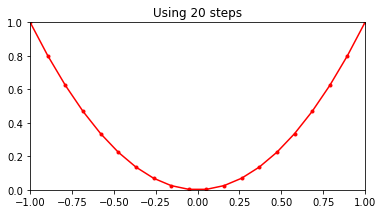

In [2]:
for i in range(1, 21):
    
    # Clear the current figure's axes
    plt.gca().cla()
    
    # Generate the plot
    xvals = np.linspace(-1, 1, i)
    plt.plot(xvals, xvals**2, '.-r')         # Plot range x^2 over [-1,1] with i steps
    plt.xlim(-1, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal')
    plt.title('Using %d steps' % i)
    
    # Replace the old plot with the new one
    IPython.display.display(plt.gcf())       # Tell Jupyter to show Matplotlib's current figure
    IPython.display.clear_output(wait=True)  # Tell Jupyter to clear whatever it's currently showing
    time.sleep(0.02)                         # Small delay to slow animation (optional)

**Run the code cell below** to define a plotting function that is useful for visualizing the weights of neural networks and images.

In [3]:
x1lim = (-4, 4)
x2lim = (-4, 4)

def plot_discriminator(discriminator):
    """Plot the class probabilities of the discriminator (red: fake, blue: real)."""
    x1, x2 = torch.meshgrid(torch.linspace(*x1lim, 100), torch.linspace(*x2lim, 100))
    X = torch.cat([x1.t().reshape(-1, 1), x2.t().reshape(-1, 1)], 1)
    y = torch.sigmoid(discriminator(X))
    y = y.view(x1.shape).detach()
    plt.imshow(1-y, extent=x1lim+x2lim, origin='lower', vmin=0, vmax=1, cmap='bwr', alpha=0.25)
    if y.min() < 0.5 and y.max() > 0.5:
        plt.contour(x1.t(), x2.t(), y, levels=[0.5], colors='k', linewidths=1, alpha=0.15)
    plt.xlim(*x1lim)
    plt.ylim(*x2lim)
    plt.gca().set_aspect('equal')

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Learn how a GAN works

Exercise 1.1&ndash;1.5 ask you to generate a synthetic training set, then to train a GAN to mimick your synthetic data using the existing starter code.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.1 &mdash; Write a function to sample the training set $\{\mathbf{x}_i\}_{i=1}^{N}$

You are given a synthetic training set and must write a function that returns a random subsample. The function you write will be by the GAN training loop.

**Run the code cell below** to first define a full synthetic training set.

In [4]:
torch.manual_seed(0)  # Make cell output reproducible
W_real = torch.tensor([[1.5, 0.0], [0.0, 3.0]])
b_real = torch.tensor([-3.0,  -2.0])
X_real = torch.rand((1000, 2)) @ W_real + b_real

**Implement the *sample_real_data* function.** Use **[torch.randint](https://pytorch.org/docs/1.2.0/torch.html?highlight=randint#torch.randint)** in your answer.

In [72]:
def sample_real_data(batch_size):
    """
    Returns batch_size samples randomly selected from X_real, with replacement.
    The resulting array has shape (batch_size, 2).
    """
    # Your code here. Aim for 1-3 lines.
    b = torch.randint(0, len(X_real), size=(batch_size,))
    return X_real[b]

**Check your answer** by running the code cell below.

In [73]:
_X = sample_real_data(5)
assert isinstance(_X, torch.FloatTensor), "Expected a tensor of dtype float32."
assert _X.shape == (5, 2), "Expected tensor of shape (batch_size, 2)."
for _x in _X:
    assert torch.all(_x == X_real, 1).sum() == 1, "Expected each sample in batch to come from X_real"
assert not torch.equal(_X, sample_real_data(5)), "Expected different samples each time called."
assert sample_real_data(13).shape == (13, 2)
assert sample_real_data(2000).shape == (2000, 2), "Forgot to sample with replacement?"
print("Looks good!")

Looks good!


**Plot a sample of training data.** Call your *sample_real_data* function to plot 100 training samples. Your plot should look like
![image](img/sample_real_data_uniform.png)

Text(0.5, 1.0, 'sample of real data $x_{i}$')

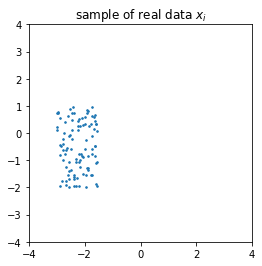

In [91]:
torch.manual_seed(0)  # Make cell output reproducible

# Your plotting code here. Aim for 5-7 lines.
#print(sample_real_data(100).shape)
plt.figure(figsize=(4,4))
plt.axis([-4, 4, -4, 4])
plt.xticks(np.arange(-4,5,step=2))
plt.scatter(sample_real_data(100)[:,0],sample_real_data(100)[:,1],marker='.',s = 10)
plt.title(r'sample of real data $x_{i}$')

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.2 &mdash; Create a source of noise $\mathbf{z}$

Recall that a GAN starts from a value $\mathbf{z}$ that was sampled from a standard random distribution (*e.g.* uniform, normal) and then transforms it into a new data point $\mathbf{\hat{x}} = G(\mathbf{z})$.

**Implement the *sample_fake_noise* function.** Use the **[torch.rand](https://pytorch.org/docs/stable/torch.html?highlight=rand#torch.rand)** function to generate random samples $\mathbf{z} \sim U(-\frac{1}{2}, \frac{1}{2})^2$, *i.e.* in the 2-dimensional unit square centered at the origin where $z_1,z_2 \in [-\frac{1}{2}, \frac{1}{2}]$.

In [100]:
def sample_fake_noise(batch_size):
    """
    Returns batch_size samples of 2-dimensional noise on the unit inverval [-0.5, 0.5].
    The returned tensor has shape (batch_size, 2).
    """
    # Your code here. Aim for 1-2 lines.
    return (torch.rand(batch_size,2)).uniform_(-0.5,0.5)


**Check your answer** by running the code cell below.

In [101]:
_Z = sample_fake_noise(5)
assert isinstance(_Z, torch.FloatTensor), "Expected a tensor of dtype float32"
assert _Z.shape == (5, 2), "Expected noise to have shape (batch_size, 2)"
assert torch.all((_Z >= -0.5) & (_Z <= 0.5)), "Expected uniform distribution centered at 0"
print("Looks good!")

Looks good!


**Plot a sample of your noise.** Your plot should look like
![image](img/sample_noise_uniform.png)

Text(0.5, 1.0, 'sample of real data $x_{i}$')

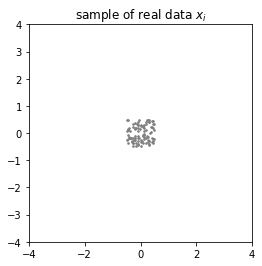

In [103]:
torch.manual_seed(1)  # Make cell output reproducible

# Your plotting code here. Aim for 5-7 lines.
plt.figure(figsize=(4,4))
plt.axis([-4, 4, -4, 4])
plt.xticks(np.arange(-4,5,step=2))
plt.scatter(sample_fake_noise(100)[:,0],sample_fake_noise(100)[:,1],marker='.',s = 10 ,c='grey')
plt.title(r'sample of real data $x_{i}$')

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.3 &mdash; Create an untrained GAN generator

You are asked to define a generator model in PyTorch. Your generator $G:\mathbb{R}^2 \rightarrow \mathbb{R}^2$ should be a linear transformation, taking the form $G(\mathbf{z}) = \mathbf{W} \mathbf{z} + \mathbf{b}$ for some trainable parameters $\mathbf{W}, \mathbf{b}$.

**Write a few lines of code** to create a *generator* variable that refers to a PyTorch module implementing the the above transformation. You can use the built-in transformations provided by PyTorch, so this is no different than in Lab 8.

In [116]:
torch.manual_seed(5)  # Make cell output reproducible

# Your code here. Aim for 1-3 lines.
generator = torch.nn.Sequential(
    torch.nn.Linear(2, 2)
)

**Check your answer** by running the code cell below.

In [117]:
assert "generator" in globals(), "Expected generator variable to be defined."
assert isinstance(generator, torch.nn.Module), "Generator should be a torch module of some type."
assert generator(torch.zeros((5, 2))).shape == (5, 2), "Output seems to be wrong shape/dimension."
print("Looks good!")

Looks good!


**Implement the *sample_fake_data* function.** Use your *sample_fake_noise* function from earlier. Obviously your function should make use of the *generator* variable you defined earlier.

In [ ]:
def sample_fake_data(batch_size):
    """
    Returns batch_size samples from the current generator.
    The returned tensor has shape (batch_size, 2).
    """
    # Your code here. Aim for 1-2 lines.


**Plot a sample of fake data** alongside a sample of noise. Recall that your generator has weights $\mathbf{w}$ that are initialized to be small random values, so you should see some arbitrary transformation like this:
![image](img/sample_fake_data_uniform.png)

*Note.* When you try to plot a PyTorch tensor, Matplotlib asks the tensor to convert itself to a Numpy array. However, any tensor that is the output of a PyTorch "Module" will have gradient tracking enabled (the tensor will be "attached" to a compute graph). You may need to call the **[detach](   https://pytorch.org/docs/1.2.0/tensors.html?highlight=detach#torch.Tensor.detach)** method on such tensors before you can plot with them.

In [ ]:
# Your plotting code here. Aim for 7-9 lines.


<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.4 &mdash; Create an untrained GAN discriminator

You are asked to define a discriminator model in PyTorch. Your discriminator $D:\mathbb{R}^2 \rightarrow \mathbb{R}$ should also be a linear transformation, taking the form $D(\mathbf{x}) = \mathbf{W} \mathbf{x} + \mathbf{b}$ for some trainable parameters $\mathbf{W}, \mathbf{b}$. The sigmoid for binary classification will be applied later.

**Write a few lines of code** to create a *discriminator* variable that refers to a PyTorch module implementing the the above transformation.

In [ ]:
torch.manual_seed(5)  # Make cell output reproducible

# Your code here. Aim for 1-3 lines.


**Check your answer** by running the code cell below.

In [ ]:
assert "discriminator" in globals(), "Expected discriminator variable to be defined."
assert isinstance(discriminator, torch.nn.Module), "Discriminator should be a torch module."
assert discriminator(torch.zeros((5, 2))).shape == (5, 1), "Output seems to be wrong shape/dimension."
print("Looks good!")

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.5 &mdash; Train your GAN on the synthetic training data

The GAN training objective includes:
* a binary cross entropy loss applied to the output of the discriminator
* a stochastic gradient descent optimizer for the discriminator weights
* a stochastic gradient descent optimizer for the generator weights
* a function to do forward and backpropagation for the discriminator
* a function to do forward and backpropagation for the generator

**Run the code cell below** to set up these elements so that training is ready.

In [ ]:
loss = torch.nn.BCEWithLogitsLoss()
discriminator_optim = torch.optim.SGD(discriminator.parameters(), lr=0.01, momentum=0.8)
generator_optim     = torch.optim.SGD(generator.parameters(),     lr=0.01, momentum=0.8)

# Use 100 samples of real and fake data per update.
batch_size = 100

# Create vectors to act as binary training targets
y_real = torch.ones((batch_size, 1))   # 1 means "this data point is real"
y_fake = torch.zeros((batch_size, 1))  # 0 means "this data point is fake"

def update_discriminator():
    discriminator.zero_grad()         # Get ready to accumulate gradient for discriminator weights.
    
    X = sample_real_data(batch_size)  # Sample real data.
    y = discriminator(X)              # Predict real or fake.
    l = loss(y, y_real)               # Discriminator wants to predict "real" for these cases.
    l.backward()                      # Accumulate discriminator gradient.
    
    X = sample_fake_data(batch_size).detach()  # Sample fake data. (Detach so no generator gradient.)
    y = discriminator(X)                       # Predict real or fake.
    l = loss(y, y_fake)                        # Discriminator Wants to predict "fake" for these.
    l.backward()                               # Accumulate discriminator gradient.
    
    discriminator_optim.step()        # Use gradient to improve the discriminator!

def update_generator():
    generator.zero_grad()             # Get ready to accumulate gradient for generator weights.
    
    X = sample_fake_data(batch_size)  # Sample fake data. (Don't detach, so backprop to generator.)
    y = discriminator(X)              # Predict real or fake.
    l = loss(y, y_real)               # Generator wants discriminator to predict "real" for these.
    l.backward()                      # Accumulate generator gradient, backprop through discriminator!
    
    generator_optim.step()            # Use gradient to improve generator!

**Add plotting code to the GAN training loop below.** You should use the "plot updating" technique demonstrated at the start of this lab. If you only ran the training loop for 1 step the first plot should look like this:
![image](img/gan_training_linear_epoch0001.png)
After 500 steps your plot should look more like this:
![image](img/gan_training_linear_epoch0500.png)
You can re-run the code cell to continue training an additional 500 steps, from whatever the most recent parameters were. If you want to reset the training, you must go back and re-run the code cell defining *generator* and all subsequent code cells.

*Tip 1:* Plotting is slow, so if you want to speed up training, consider only updating the plot every 10th step. You can use the module `%` operator to do this.

*Tip 2:* If you wish the points in your plot to remain consistent, rather than being a different random sample each time, you can use the *torch.manual_seed* function immediately prior to plotting.

In [ ]:
num_steps = 2000
for step in range(1, num_steps+1):
    update_discriminator()
    update_generator()
                
    if step == 1 or (step % 10 == 0):
        plt.gca().cla()
        
        torch.manual_seed(0)  # Resample the same data each time
        
        # Your plotting code here. Aim for 8-12 lines.


Since we generate both the training data $\mathbf{x}_i$ and the random noise $\mathbf{z}$ from a uniform distribution, we know that a linear generator $G$ is capable, in principle, of fitting to this data.

However, given that the linear discriminator $D$ is only capable of a linear decision boundary in feature space, you may observe that the best it can do is to center the fake points within the cloud of blue points. To get a tighter fit to the data, a more powerful discriminator is required.


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 2. Modify your generator and discriminator architectures

Exercise 2.1&ndash;2.2 ask you to try more sophisticated generator and discriminator architectures, to understand how they impact the training dynamics and the complexity of the distribution.

Rather than writing new code, you will have to go back to Exercise 1 and edit your existing answers. *Remember to always re-run all code cells that follow your edit.* Otherwise some of your code cells may be keeping references to old versions of your objects (old generator, old discriminator, etc.)

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.1 &mdash; Use quadratic features in your discriminator

You should learn how to define your own PyTorch module, as a class inherited from **[torch.nn.Module](https://pytorch.org/docs/1.2.0/nn.html#torch.nn.Module)**.

Go back to Exercise 1.4 and define a new custom module class called *QuadraticFeatures*. The purpose is to transform data $\mathbf{x}=\begin{bmatrix}x_1 & x_2 \end{bmatrix}$ into a 5-dimensional feature space $\mathbf{\phi}(\mathbf{x})=\begin{bmatrix} x_1 & x_2 & \frac{1}{10}x_1^2 & \frac{1}{10}x_2^2 & \frac{1}{10}x_1 x_2\end{bmatrix}$ for classification. The discriminator can thus produce non-linear decision boundaries in the original data space, and have more discriminative power.

*Tip:* The **[torch.stack](https://pytorch.org/docs/1.2.0/torch.html?highlight=stack#torch.stack)** function may be convenient.

After re-running all the necessary code cells (including the code cell resetting the *generator*) and training for many steps, you should see a fit more like this:

![image](img/gan_training_quadratic_epoch5000.png)

(As for the $\frac{1}{10}$ coefficients, remember what happens to gradient-based training if you don't scale down the quadratic features!)

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.2 &mdash; Use a ReLU layer in your discriminator

Go back to Exercise 1.4 and, instead of quadratic features, use a discriminator that is a 2-50-1 ReLU neural network. In other words, add a hidden layer with 50 ReLU units to your discriminator.

After re-running all the necessary code cells, you should see a fit more like this:

![image](img/gan_training_relu_epoch2000.png)

<div style="border-bottom: 3px solid black;"></div>

### Other exercises

* Try adding hidden layers to your generator, too!
* Try creating multi-modal training data!
* Try training a GAN on MNIST digits! (may take time)